To run this notebook, please place it in the "code" directory of the provided files you downloaded from kaggle.

Everything runs with the ```altegrad-lab4``` environment or whichever env you used for the last 3 labs, plus the packages in the next cell

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from extract_feats import extract_feats
import networkx as nx
import re

All the prompts hold 7 features **exactly**. They are :
- an index that is contained in the name of the file in the train/valid sets and that are prepended to the prompt in the test.
- The number of nodes
- number of edges
- average degree
- number of triangles
- clustering coef
- max k-core
- number of communities

Let's extract them using the dedicated and provided function.




In [2]:
parent_train = '../data/train/description/'
features_list = []  # will hold all the features
for txt_file in os.listdir(parent_train):
    index = txt_file[6:-4]
    features_list.append([int(index)] + extract_feats(parent_train + txt_file))


In [3]:
df_feats = pd.DataFrame(features_list, columns=['index', 'nodes', 'edges', 'degree', 'triangles', 'clust_coef', 'max_k_core', 'communities'])
df_feats.set_index('index', inplace=True)
df_feats.sort_index(inplace=True)

In [4]:
df_feats.head()

,nodes,edges,degree,triangles,clust_coef,max_k_core,communities
index,,,,,,,
0,10.0,5.0,1.000000,0.0,0.000000,1.0,5.0
1,43.0,321.0,14.930233,545.0,0.350332,11.0,4.0
2,12.0,37.0,6.166667,38.0,0.550725,5.0,2.0
3,29.0,269.0,18.551724,1067.0,0.663282,15.0,3.0
4,47.0,828.0,35.234043,7268.0,0.764248,29.0,3.0


## Graphs' structure

In [5]:
df_feats.describe()

,nodes,edges,degree,triangles,clust_coef,max_k_core,communities
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,30.606375,226.261375,12.925326,1389.915125,0.506973,11.442125,3.347500
std,11.808445,234.405327,10.174713,2795.085485,0.321210,9.993342,1.450261
min,10.000000,5.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,21.000000,49.000000,4.615385,30.000000,0.269589,4.000000,2.000000
50%,31.000000,139.000000,10.310096,278.000000,0.514626,9.000000,3.000000
75%,41.000000,327.000000,18.000000,1306.000000,0.755695,16.000000,4.000000
max,50.000000,1225.000000,49.000000,19600.000000,1.000000,49.000000,16.000000


Clearly they did not do something too crazy for the graph generation.

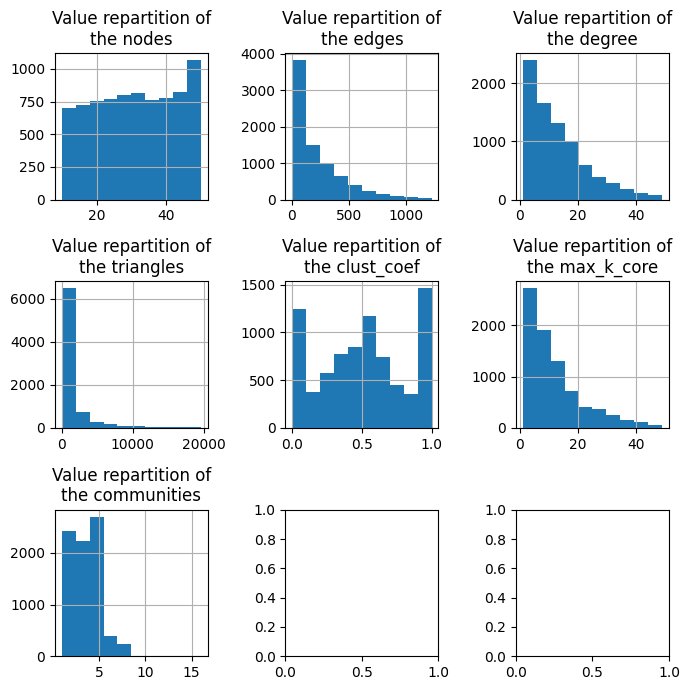

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(7,7))
for i, feat in enumerate(df_feats.columns):
    ax = axes[i//3][i%3]
    df_feats[feat].hist(ax=ax)
    ax.set_title(f"Value repartition of\nthe {feat}")
plt.tight_layout()
plt.show()

The number of nodes is not exactly uniform. A few graphs have 'extreme' features such as a high number of communities or triangles. This is to be kept in mind in case we want to generate data, as a model that performs on such rare graphs probably needs to see more of them than in what's provided.

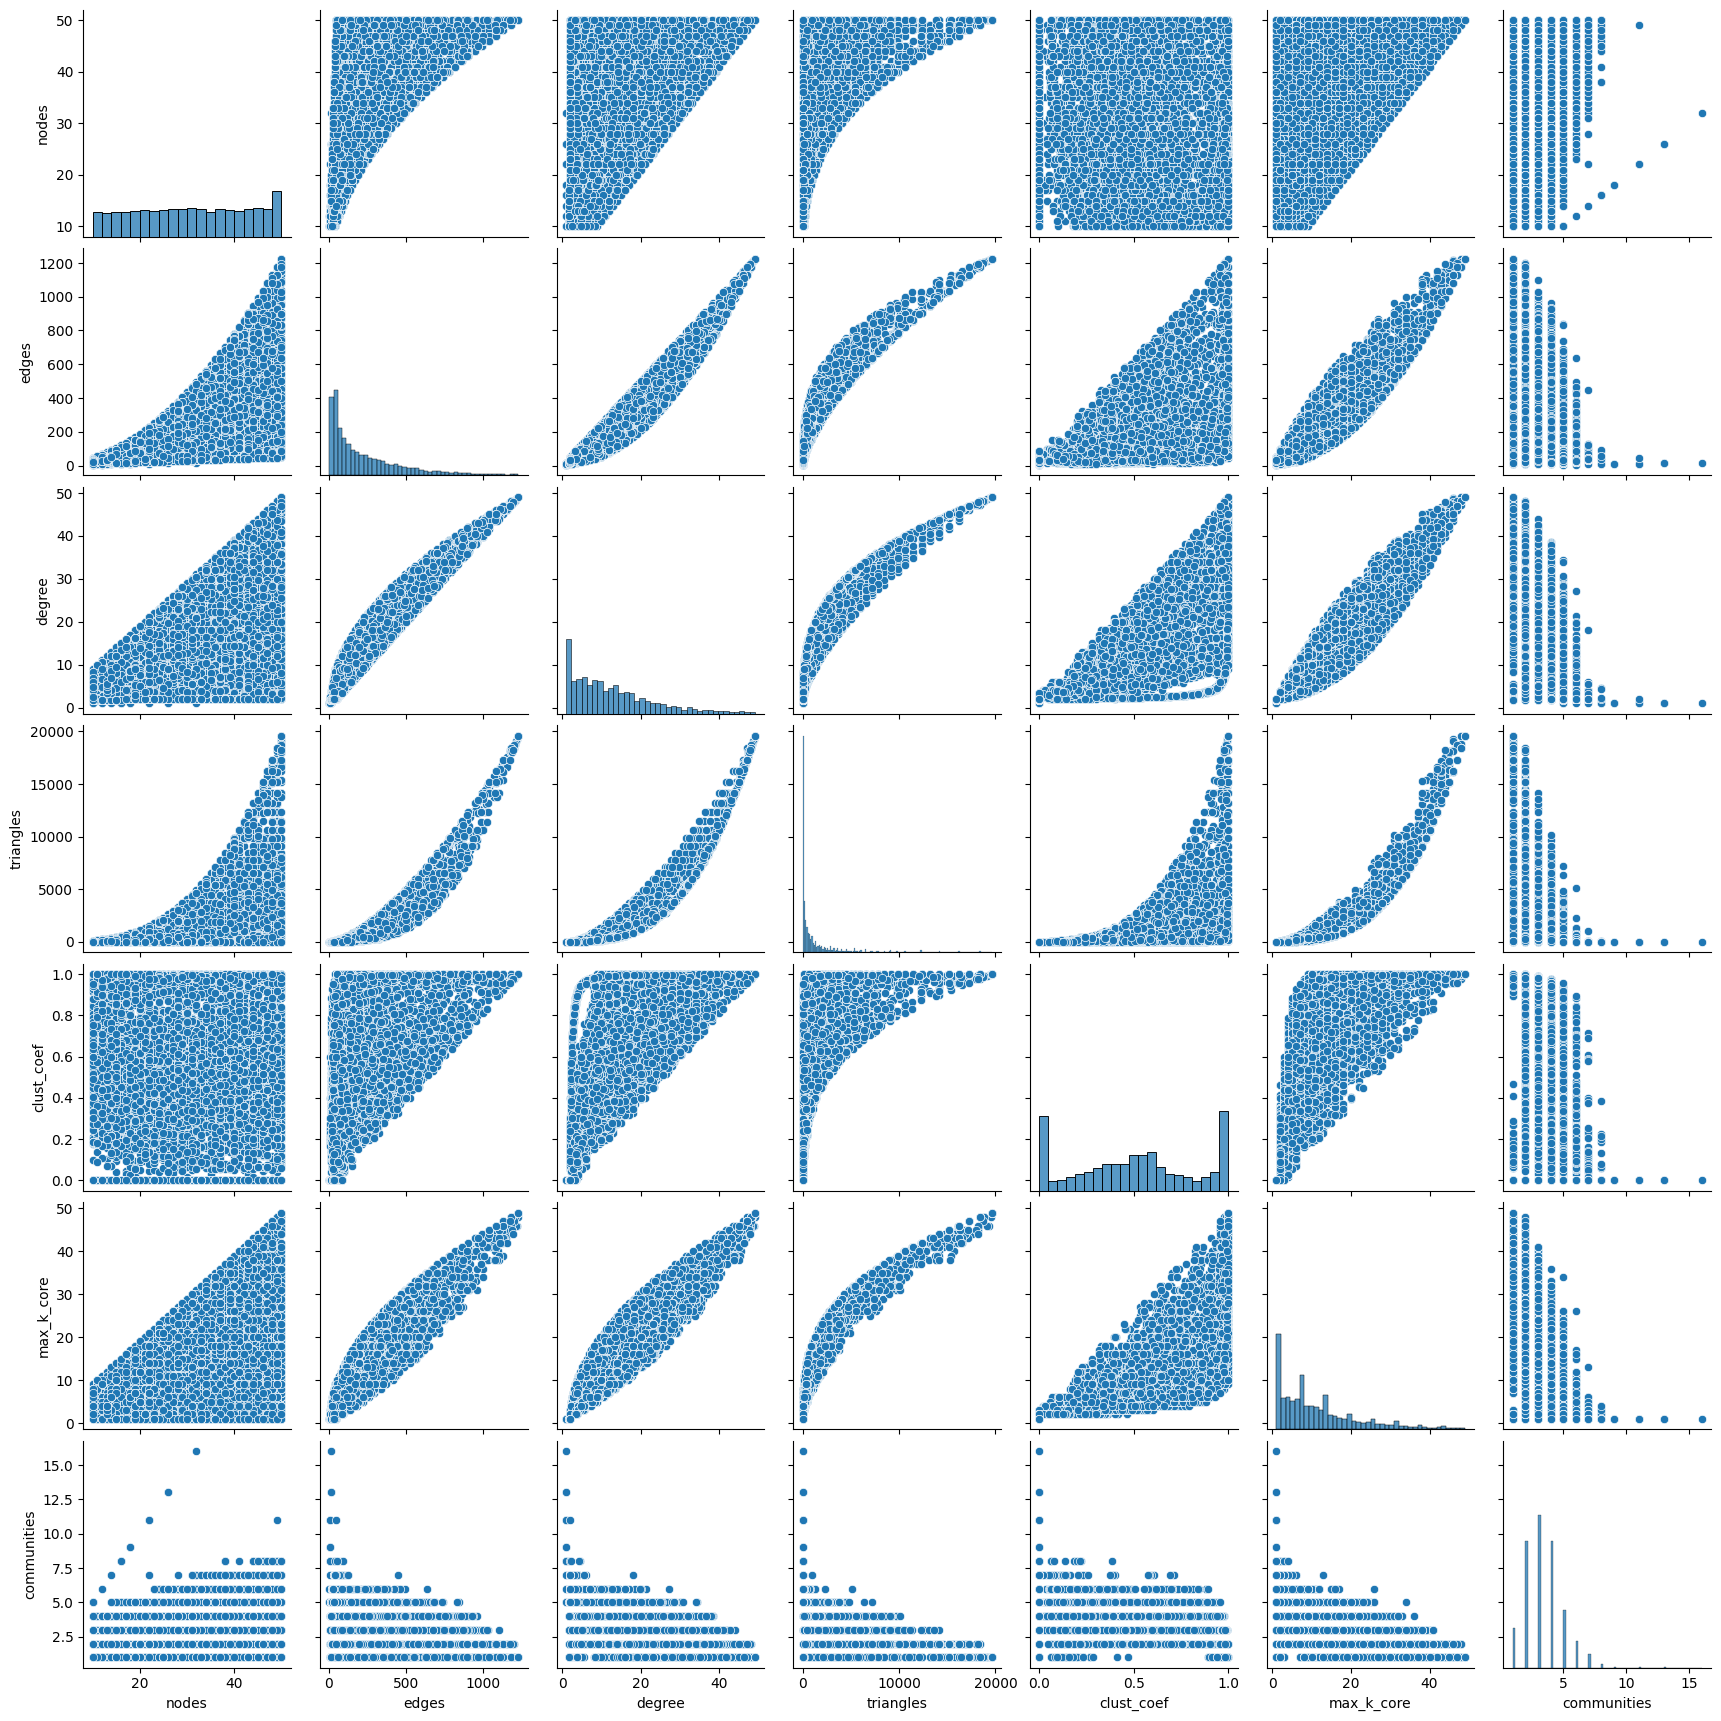

In [7]:
sns.pairplot(df_feats)


Okay so now it's going to be feelings not facts. I feel like they had 2 algorithms to generate graphs. A lot of these pairplots show relationship that somewhat makes sense, but some of them seem to have two superposed pairplots. Take a look at :
- nodes vs communities. We have a block with a slight increase of the # of communities along the number of nodes **and** a weird slope of a handful of graphs that have *exactly* half the communities as there are nodes.
- clust_coef vs degrees. Interesting that we have a block **and** a **distinct** line that wraps away from it, leaving a noticeable region of the graph blank.
- clust_coef vs nodes. Look a the line at the bottom comprising graphs with a clustering coefficient of 0.
- the max k core histogram. Funny that it's not regularly decreasing.

## Prompts' structure


It seems that they cooked something very quickly, every prompt has the same layout with just a couple sub-sentences for each part. This is obvious when openning the test set. Let's get all the strings and strip away the numbers in a similar way as their function ```extract_feats``` does but replacing the numbers by some kind of token to represent the number (e.g. the sentence "in this graph there are 43 nodes connected by 817 edges" becomes "in this graph there are [nodes] nodes connected by [edges] edges")

In [8]:
features = df_feats.columns.to_list()

def replace_numbers_with_features(sentence, features):
    """replaces the numbers by a string with the corresponding feature"""
    blanked = re.sub(r'\d+\.\d+|\d+', 'XXX', sentence)
    chunks = blanked.split('XXX')
    result = ''
    for i, feature in enumerate(features):
        result += chunks[i] + '[' + feature + ']'
    
    return result + chunks[-1]

parent_train = '../data/train/description/'
indexes = []  # will hold indexes
prompt_structures = []  # will hold all the prompt structures
for txt_file in os.listdir(parent_train):
    indexes.append(int(txt_file[6:-4]))
    with open(parent_train + txt_file, 'r') as f:
        prompt_structures.append(replace_numbers_with_features(f.read(), features))


In [9]:
df_prompts = pd.DataFrame(prompt_structures, columns=['prompt_structure'], index=indexes)
df_prompts.sort_index(inplace=True)

In [10]:
df_prompts.head()

,prompt_structure
0,This graph comprises [nodes] nodes and [edges]...
1,"In this graph, there are [nodes] nodes connect..."
2,This graph comprises [nodes] nodes and [edges]...
3,"In this graph, there are [nodes] nodes connect..."
4,"In this graph, there are [nodes] nodes connect..."


In [17]:
df_prompts.value_counts()

prompt_structure                                                                                                                                                                                                                                                                                                                                                                    
In this graph, there are [nodes] nodes connected by [edges] edges. On average, each node is connected to [degree] other nodes. Within the graph, there are [triangles] triangles, forming closed loops of nodes. The global clustering coefficient is [clust_coef]. Additionally, the graph has a maximum k-core of [max_k_core] and a number of communities equal to [communities].    4024
This graph comprises [nodes] nodes and [edges] edges. The average degree is equal to [degree] and there are [triangles] triangles in the graph. The global clustering coefficient and the graph's maximum k-core are [clust_coef] and [max_k_core] res

Exactly two prompts. We can generate data with the correct structure easily, the one thing to elucidate is how the graphs were generated exactly, I am guessing like they showed us in the last lab + some bipartite graphs, but this is to find out. Good thing we have the data repartition above so we can try things out and see what somewhat matches.

## Actual graph structures

Let's do some viz :

In [12]:
def show_graphs(graphs_dir, n_plots=25, seed=None):
    """shows n_plots graphs from graphs_dir, picked at random unless a seed is passed"""
    if seed is not None:
        np.random.seed(seed)
    #get all files in a list
    edgelists_list = os.listdir(graphs_dir)
    #pick which ones will be used
    edgelists = np.random.choice(edgelists_list, n_plots)

    n_cols = 5
    n_rows = n_plots // 5 + int(bool(n_plots % 5))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,10))

    for i, file in enumerate(edgelists):
        ax = axes[i//n_cols][i%n_cols]
        G = nx.read_edgelist(graphs_dir + file)
        nx.draw(G, ax=ax, node_size=10, width = .35)
        ax.set_title(file[:-9])
plt.show()

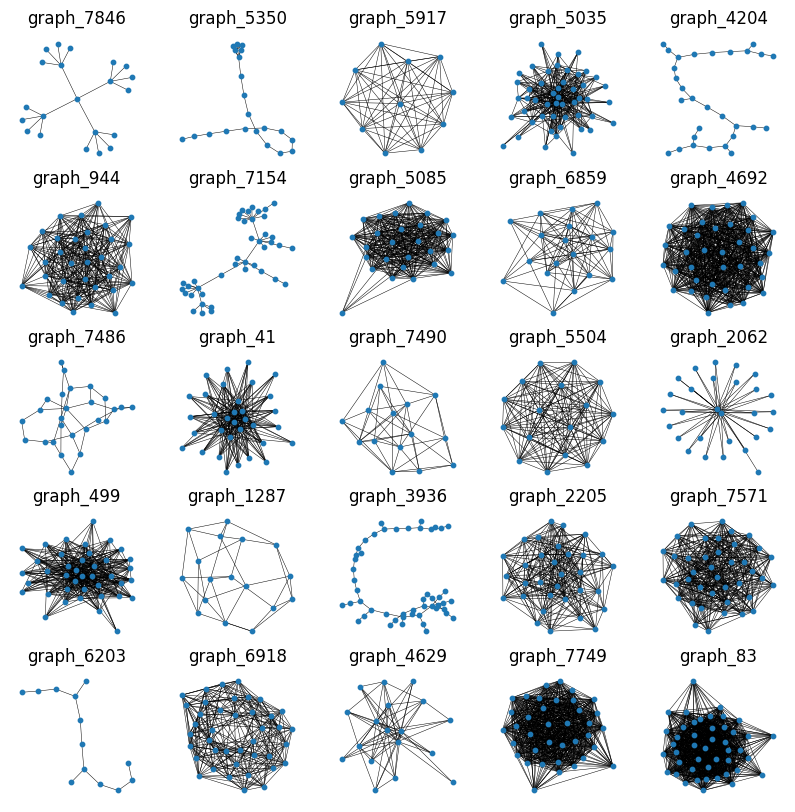

In [13]:
show_graphs('../data/train/graph/', 25, 0)

It is in fact looking like 2 (maybe 3  or 4?) algorithms used for graph generation. 

Clearly there is one that generates chains that end by some kind of cluster (the string shapde graphs). For the other ones there might one or several algorithms :
- Maybe it is the random graph generator we used in the lab ```nx.fast_gnp_random_graph```, with varying values of $p$ to connect nodes.
- Maybe they just deciced some graphs would be complete.
- Maybe some graphs are generated with ```nx.fast_gnp_random_graph```, and some other follow different procedures (I am thinking about the star shaped, tree like and "hairy strings" shaped graphs).

It might be tough to reverse engineer everything they did. We can either somewhat try **or** just take their graphs, slightly change them (add and remove a handful of nodes and recompute all features). This way we can generate data that is close to what they generated. It's just an idea.

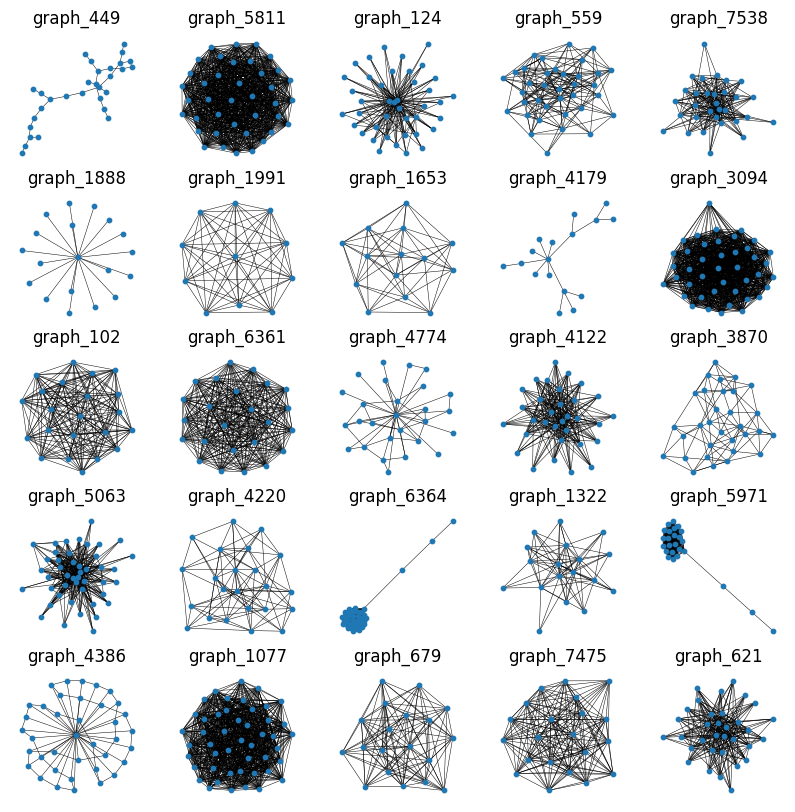

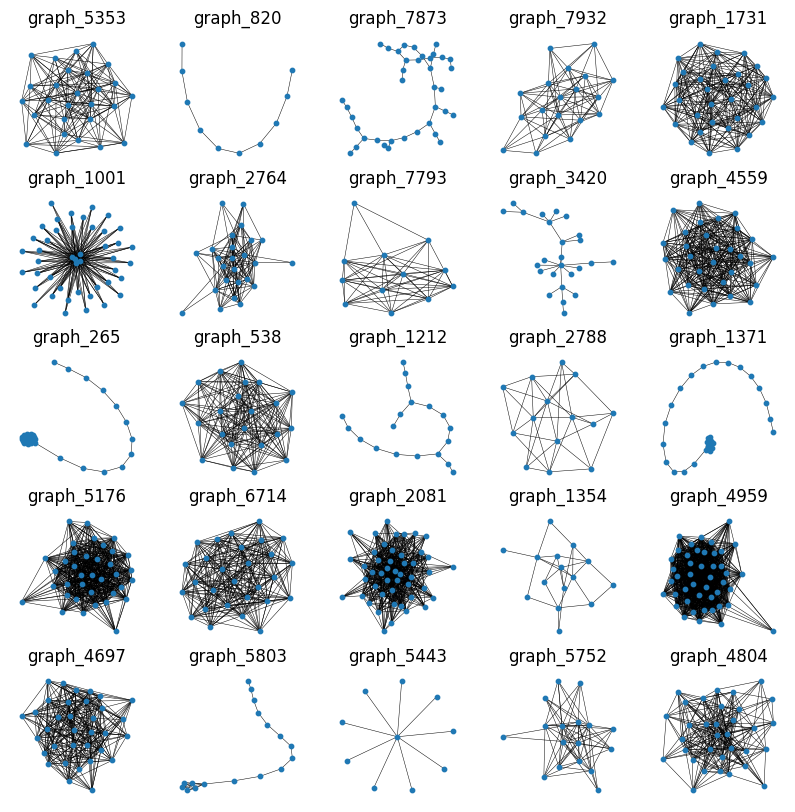

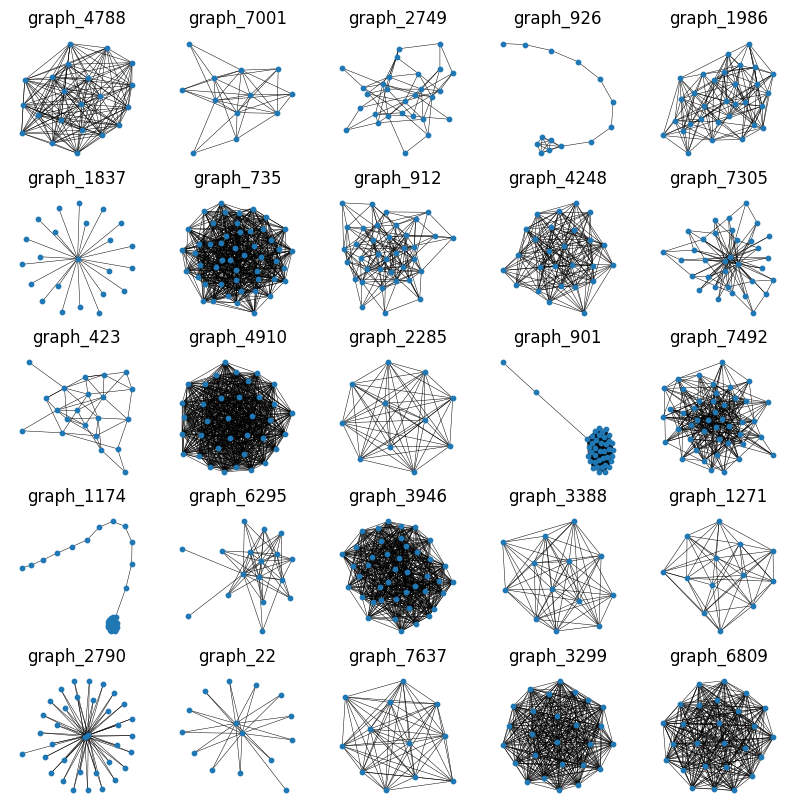

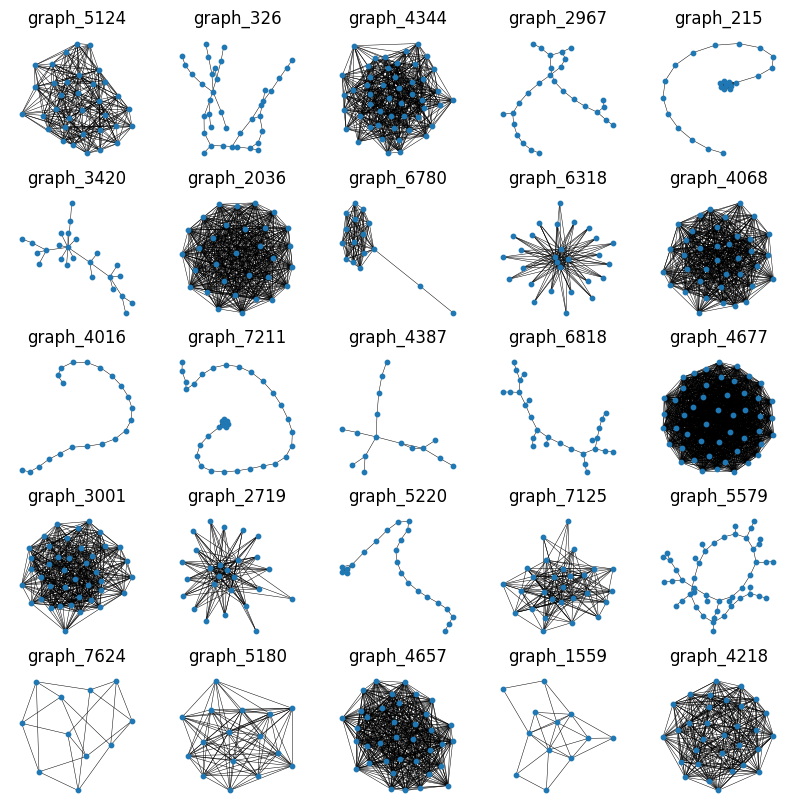

In [14]:
for seed in range(1, 5):
    show_graphs('../data/train/graph/', 25, seed)